## Supervised Detection of Human Actions with ResNet18 ##

Most code aside from data processing and model definition adapted from a [kaggle project](https://www.kaggle.com/code/hitman1309/human-action-recognition-with-pytorch) by Hitesh Gupta, which is provided under Apache License, v2.0.





In [ ]:
!pip install torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.3/204.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 93.8 MB/s eta 0:

In [ ]:
import torch
from torch import nn, optim
from torchvision import transforms, models

from torch.utils.data import DataLoader, Dataset
from torch_snippets import *


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import numpy as np
import cv2
from glob import glob
import pandas as pd
import os
sns.set_theme()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/My Drive/AML-data/HARkaggle.zip'

destination_folder = '/content/'

# Unzip the file
!unzip "$zip_path" -d "$destination_folder"

Streaming output truncated to the last 5000 lines.
  inflating: /content/Human Action Recognition/train/Image_5499.jpg  
  inflating: /content/Human Action Recognition/train/Image_55.jpg  
  inflating: /content/Human Action Recognition/train/Image_550.jpg  
  inflating: /content/Human Action Recognition/train/Image_5500.jpg  
  inflating: /content/Human Action Recognition/train/Image_5501.jpg  
  inflating: /content/Human Action Recognition/train/Image_5502.jpg  
  inflating: /content/Human Action Recognition/train/Image_5503.jpg  
  inflating: /content/Human Action Recognition/train/Image_5504.jpg  
  inflating: /content/Human Action Recognition/train/Image_5505.jpg  
  inflating: /content/Human Action Recognition/train/Image_5506.jpg  
  inflating: /content/Human Action Recognition/train/Image_5507.jpg  
  inflating: /content/Human Action Recognition/train/Image_5508.jpg  
  inflating: /content/Human Action Recognition/train/Image_5509.jpg  
  inflating: /content/Human Action Recogni

In [ ]:
file_path = '/content/Human Action Recognition/train/Image_10169(1).jpg'
model_save_path = '/content/drive/My Drive/AML-data/resnetmodel2_epochs.pth'
# Check if the file exists before trying to delete it
if os.path.isfile(file_path):
    os.remove(file_path)
    print(f"File {file_path} has been removed.")
else:
    print(f"File {file_path} does not exist.")

File /content/Human Action Recognition/train/Image_10169(1).jpg has been removed.


In [ ]:
DIR = "/content/Human Action Recognition/"
TRAIN_DIR=f"{DIR}train"
TEST_DIR=f"{DIR}test"
TRAIN_VAL_DF = "/content/Human Action Recognition/Training_set.csv"

In [ ]:
train_val_data=glob(TRAIN_DIR+'/*.jpg')
# remove duplicate
train_data, val_data = train_test_split(train_val_data, test_size=0.15,
                                       shuffle=True, random_state=11)
print('Train Size', len(train_data))
print('Val Size', len(val_data))

Train Size 10710
Val Size 1890


In [ ]:
df=pd.read_csv(f"{DIR}Training_set.csv")
df.head()

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop


In [ ]:
ind2cat = sorted(df['label'].unique().tolist())
cat2ind = {cat: ind for ind, cat in enumerate(ind2cat)}

In [ ]:
class HumanActionData(Dataset):
    def __init__(self, file_paths, df_path, cat2ind):
        super().__init__()
        self.file_paths = file_paths
        self.cat2ind = cat2ind
        self.df = pd.read_csv(df_path)
        self.transform = transforms.Compose([
            transforms.Resize([224, 244]),
            transforms.ToTensor(),
            # std multiply by 255 to convert img of [0, 255]
            # to img of [0, 1]
            transforms.Normalize((0.485, 0.456, 0.406),
                                 (0.229*255, 0.224*255, 0.225*255))]
        )

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, ind):
        file_path = self.file_paths[ind]
        #print(f"Processing file: {file_path}")
        itarget = int(os.path.basename(file_path)[6:-4])
        target = self.df.iloc[itarget-1]['label']
        target = self.cat2ind[target]
        img = Image.open(file_path).convert('RGB')
        return img, target

    def collate_fn(self, data):
        imgs, targets = zip(*data)
        imgs = torch.stack([self.transform(img) for img in imgs], 0)
        imgs = imgs.to(device)
        targets = torch.tensor(targets).long().to(device)
        return imgs, targets

    def choose(self):
        return self[np.random.randint(len(self))]

In [ ]:
train_ds = HumanActionData(train_data, TRAIN_VAL_DF, cat2ind)
train_dl = DataLoader(train_ds, batch_size=128, shuffle=True,
                      collate_fn=train_ds.collate_fn,
                      drop_last=True)

val_ds = HumanActionData(val_data, TRAIN_VAL_DF, cat2ind)
val_dl = DataLoader(val_ds, batch_size=128, shuffle=True,
                    collate_fn=val_ds.collate_fn,
                    drop_last=True)

In [ ]:
class ActionClassifier(nn.Module):
    def __init__(self, ntargets):
        super().__init__()
        resnet = models.resnet18(pretrained=True, progress=True)
        modules = list(resnet.children())[:-1] # delete last layer
        self.resnet = nn.Sequential(*modules)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(resnet.fc.in_features),
            nn.Dropout(0.2),
            nn.Linear(resnet.fc.in_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, ntargets)
        )

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        return x

In [ ]:
classifier = ActionClassifier(len(ind2cat))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


In [ ]:
def train(data, classifier, optimizer, loss_fn):
    classifier.train()
    imgs, targets = data
    outputs = classifier(imgs)
    loss = loss_fn(outputs, targets)
    preds = outputs.argmax(-1)
    acc = (sum(preds==targets) / len(targets))
    classifier.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, acc

In [ ]:
@torch.no_grad()
def validate(data, classifier, loss_fn):
    classifier.eval()
    imgs, targets = data
    outputs = classifier(imgs)
    loss = loss_fn(outputs, targets)
    preds = outputs.argmax(-1)
    acc = (sum(preds==targets) / len(targets))
    return loss, acc

In [ ]:
n_epochs = 25
log = Report(n_epochs)
classifier = ActionClassifier(len(ind2cat)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10,
                                     gamma=0.5)

In [ ]:
for epoch in range(n_epochs):
    n_batch = len(train_dl)
    for i, data in enumerate(train_dl):
        train_loss, train_acc = train(data, classifier,
                                      optimizer, loss_fn)
        pos = epoch + ((i+1)/n_batch)
        log.record(pos=pos, train_loss=train_loss,
                   train_acc=train_acc, end='\r')
    torch.save(classifier.state_dict(), model_save_path+'{}'.format(epoch))
#     n_batch = len(val_dl)
#     for i, data in enumerate(val_dl):
#         val_loss, val_acc = validate(data, classifier, loss_fn)
#         pos = epoch + ((i+1)/n_batch)
#         log.record(pos=pos, val_loss=val_loss, val_acc=val_acc,
#                    end='\r')

    scheduler.step()
    log.report_avgs(epoch+1)
#saving model


Evaluation and visualization

In [ ]:
loaded_model = ActionClassifier(len(ind2cat))
loaded_model.load_state_dict(torch.load('/content/drive/My Drive/AML-data/resnetmodel2_epochs.pth2', map_location=torch.device(device)))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [ ]:
loaded_model.eval()

true_labels = []
predictions = []

with torch.no_grad():
    for inputs, labels in val_dl:
        inputs = inputs.to(torch.device('cpu'))
        labels = labels.to(torch.device(device))

        outputs = loaded_model(inputs)

        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(preds.cpu().numpy())

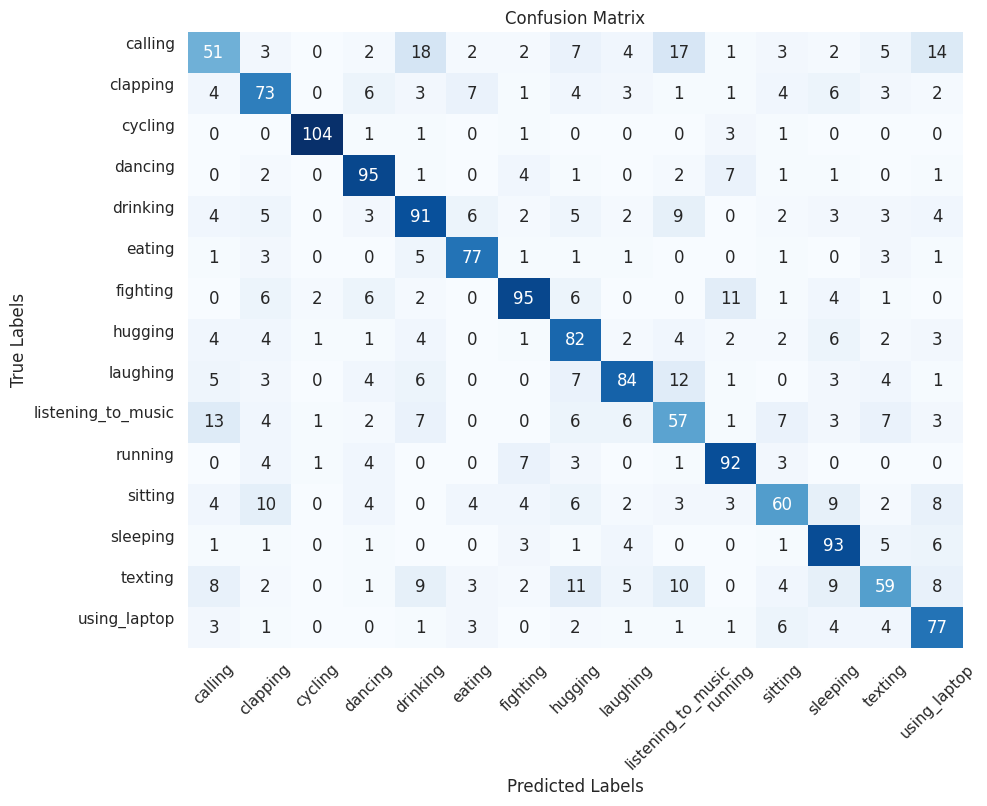

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xticks(np.arange(15) + 0.5, [ind2cat[i] for i in range(15)], rotation=45)

plt.yticks(np.arange(15) + 0.3, [ind2cat[i] for i in range(15)], rotation=0)

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
accuracy = accuracy_score(true_labels, predictions)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 66.41%
